# Project description

You work as an analyst for the telecom operator Megaline. The company offers its clients two prepaid plans, Surf and Ultimate. The commercial department wants to know which of the plans brings in more revenue in order to adjust the advertising budget.
You are going to carry out a preliminary analysis of the plans based on a relatively small client selection. You'll have the data on 500 Megaline clients: who the clients are, where they're from, which plan they use, and the number of calls they made and text messages they sent in 2018. Your job is to analyze clients' behavior and determine which prepaid plan brings in more revenue.

## Description of the plans
Note: Megaline rounds seconds up to minutes, and megabytes to gigabytes. For calls, each individual call is rounded up: even if the call lasted just one second, it will be counted as one minute. For web traffic, individual web sessions are not rounded up. Instead, the total for the month is rounded up. If someone uses 1025 megabytes this month, they will be charged for 2 gigabytes.


### Surf

1. Monthly charge: $20

2. 500 monthly minutes, 50 texts, and 15 GB of data

3. After exceeding the package limits: 
   - 1 minute: 3 cents
   - 1 text message: 3 cents
   - 1 GB of data: $10
   
### Ultimate

1. Monthly charge: $70

2. 3000 monthly minutes, 1000 text messages, and 30 GB of data

3. After exceeding the package limits:
   - 1 minute: 1 cent
   - 1 text message: 1 cent
   - 1 GB of data: $7

# Step 1. Open the data file and study the general information

In [1]:
import numpy as np
import pandas as pd
import math as mt
from scipy import stats as st
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
from functools import reduce

In [2]:
calls = pd.read_csv('/datasets/megaline_calls.csv')
internet = pd.read_csv('/datasets/megaline_internet.csv')
messages = pd.read_csv('/datasets/megaline_messages.csv')
plans = pd.read_csv('/datasets/megaline_plans.csv')
users = pd.read_csv('/datasets/megaline_users.csv')
calls.head()

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22


In [3]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
id           137735 non-null object
user_id      137735 non-null int64
call_date    137735 non-null object
duration     137735 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [4]:
len(calls)

137735

- there are no missing values in the `calls` data
- `call_date` type should be changed to date_time type
- `duration` is in floats and it should be in integers after rounding the numbers up as the calls are counted as whole numbers

In [5]:
internet.head()

,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22


In [6]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
id              104825 non-null object
user_id         104825 non-null int64
session_date    104825 non-null object
mb_used         104825 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [7]:
len(internet)

104825

- there are no missing values in the `internet` data.
- `session_date`type should be changed to date_time type
- a new column should be added instead of `mb_used` for the internet usage as the web_traffic is calcualted in GB in monthly basis and we should consider this and arrange the data accordingly

In [8]:
messages.head()

,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26


In [9]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
id              76051 non-null object
user_id         76051 non-null int64
message_date    76051 non-null object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [10]:
len(messages)

76051

- there are no missing values in the `messages` data.
- `message_date`type should be changed to date_time type

In [11]:
plans.head()

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


In [12]:
plans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
usd_monthly_pay          2 non-null int64
usd_per_gb               2 non-null int64
usd_per_message          2 non-null float64
usd_per_minute           2 non-null float64
plan_name                2 non-null object
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


- there are no missing values in the `plans` data.

In [13]:
users.head()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN


In [14]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
first_name    500 non-null object
last_name     500 non-null object
age           500 non-null int64
city          500 non-null object
reg_date      500 non-null object
plan          500 non-null object
churn_date    34 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [15]:
len(users)

500

- there are missing values in the `churn_date` column, we should be looking into them.
- `churn_date` and `reg_date` type should be changed to date_time type

## Notes and Conclusion:

1. we only have missing values in the `churn_date`column in the `users` data and we should be looking into it
2. all of the `date` columns should be changed to data_time type
3. the `duration` and `mb_used` columns need some work and we may need to add new columns as needed

# Step 2. Data Pre-Processing

we will start by looking into each dataset individualy and process the data (type, Values and Outliers)

In [16]:
# before starting lets change all the strings to lowercase 

users['first_name'] = users['first_name'].str.lower()
users['last_name'] = users['last_name'].str.lower()
users['city'] = users['city'].str.lower()
users['plan'] = users['plan'].str.lower()
plans['plan_name'] = plans['plan_name'].str.lower()
messages['id'] = messages['id'].str.lower()
internet['id'] = internet['id'].str.lower()
calls['id'] = calls['id'].str.lower()

In [17]:
calls.head()

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22


In [18]:
# lets check if how many users are included in this dataset
calls['user_id'].nunique()

481

In [19]:
# lets change call_date to date_timetype

calls['call_date'] = pd.to_datetime(calls['call_date'])
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
id           137735 non-null object
user_id      137735 non-null int64
call_date    137735 non-null datetime64[ns]
duration     137735 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.2+ MB


In [20]:
# rounding up the duration and change the type to int.

def round_up(minute):
    rounded = mt.ceil(minute)
    return int(rounded)

calls['duration'] = calls['duration'].apply(round_up)

In [196]:
calls.head()

,id,user_id,call_date,duration,missed_call,month
0,1000_93,1000,2018-12-27,9,False,12
1,1000_145,1000,2018-12-27,14,False,12
2,1000_247,1000,2018-12-27,15,False,12
3,1000_309,1000,2018-12-28,6,False,12
4,1000_380,1000,2018-12-30,5,False,12


In [22]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
id           137735 non-null object
user_id      137735 non-null int64
call_date    137735 non-null datetime64[ns]
duration     137735 non-null int64
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 4.2+ MB


In [23]:
# lets check the values
calls.describe()

,user_id,duration
count,137735.000000,137735.000000
mean,1247.658046,7.146673
std,139.416268,5.953919
min,1000.000000,0.000000
25%,1128.000000,2.000000
50%,1247.000000,6.000000
75%,1365.000000,11.000000
max,1499.000000,38.000000


- in the `duration`column we notice that there are are with 0 values, we should check them 
- in the `duration`column we notice that max value is much higher than 75% of the values + the mean is higher than the median which indicate that there are high outliers so we should check them

In [24]:
zeros_count = calls.loc[calls['duration'] == 0].count()
zeros_count

id           26834
user_id      26834
call_date    26834
duration     26834
dtype: int64

In [25]:
zeros_percent = zeros_count/ len(calls)
zeros_percent

id           0.194823
user_id      0.194823
call_date    0.194823
duration     0.194823
dtype: float64

almost 20% of the calls are zeros therfore and a call can't have zero duration so we can assume that these are missing calls which did not go through. 

we can't drop 20% of our data so we will store these values in a separate dataset and save them for later and will make a new column in our `calls` dataset called `missed_call`indicating if the call went through or not

In [26]:
missed_calls = calls.loc[calls['duration'] == 0].copy()
missed_calls

,id,user_id,call_date,duration
19,1001_4,1001,2018-12-05,0
25,1001_13,1001,2018-12-24,0
31,1001_30,1001,2018-10-17,0
32,1001_31,1001,2018-11-03,0
34,1001_35,1001,2018-12-21,0
...,...,...,...,...
137714,1499_183,1499,2018-11-10,0
137715,1499_184,1499,2018-09-15,0
137720,1499_189,1499,2018-12-27,0
137722,1499_191,1499,2018-12-24,0


In [27]:
def missed(duration):
    if duration == 0:
        return True
    else:
        return False
    
calls['missed_call'] = calls['duration'].apply(missed)

In [28]:
calls.head()

,id,user_id,call_date,duration,missed_call
0,1000_93,1000,2018-12-27,9,False
1,1000_145,1000,2018-12-27,14,False
2,1000_247,1000,2018-12-27,15,False
3,1000_309,1000,2018-12-28,6,False
4,1000_380,1000,2018-12-30,5,False


In [29]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 5 columns):
id             137735 non-null object
user_id        137735 non-null int64
call_date      137735 non-null datetime64[ns]
duration       137735 non-null int64
missed_call    137735 non-null bool
dtypes: bool(1), datetime64[ns](1), int64(2), object(1)
memory usage: 4.3+ MB


In [30]:
calls['missed_call'].value_counts()

False    110901
True      26834
Name: missed_call, dtype: int64

as the plans are monthly so it will be usefull to add a new column specifing which month the call was made in therefore will add the column `month`

In [31]:
calls['month'] = calls['call_date'].dt.month
calls.head()

,id,user_id,call_date,duration,missed_call,month
0,1000_93,1000,2018-12-27,9,False,12
1,1000_145,1000,2018-12-27,14,False,12
2,1000_247,1000,2018-12-27,15,False,12
3,1000_309,1000,2018-12-28,6,False,12
4,1000_380,1000,2018-12-30,5,False,12


In [32]:
calls['month'].value_counts()

12    30614
11    24651
10    21064
9     16523
8     13590
7     11105
6      8221
5      5959
4      3442
3      1620
2       774
1       172
Name: month, dtype: int64

we notice an obvious trend that the numbers of calls made are increasing with every passing month. we need to look into it more later.

In [33]:
# lets check if there is any duplicates

calls.duplicated().sum()

0

there is no duplicates so we can continue with the preprocessing

now we will look into the outliers but as we concluded that the values of zero are missed calls it is not helpful to include them in the duration of calls made so we will separate the calls went through and see if these have any outliers.

In [34]:
calls_made = calls.loc[calls['missed_call'] == False].copy()
calls_made['duration'].describe()

count    110901.000000
mean          8.875907
std           5.355181
min           1.000000
25%           5.000000
50%           8.000000
75%          12.000000
max          38.000000
Name: duration, dtype: float64

after separating the missed calls we notice that the deiffernce between the mean and median is smaller which means that the data is cleaner and more natural and realistic but we still need to look at the high outliers 

In [35]:
calls_made.drop(axis=1, labels = 'missed_call' , inplace = True)

In [36]:
calls_made.head(25)

,id,user_id,call_date,duration,month
0,1000_93,1000,2018-12-27,9,12
1,1000_145,1000,2018-12-27,14,12
2,1000_247,1000,2018-12-27,15,12
3,1000_309,1000,2018-12-28,6,12
4,1000_380,1000,2018-12-30,5,12
5,1000_388,1000,2018-12-31,3,12
6,1000_510,1000,2018-12-27,6,12
7,1000_521,1000,2018-12-28,15,12
8,1000_530,1000,2018-12-28,6,12
9,1000_544,1000,2018-12-26,5,12


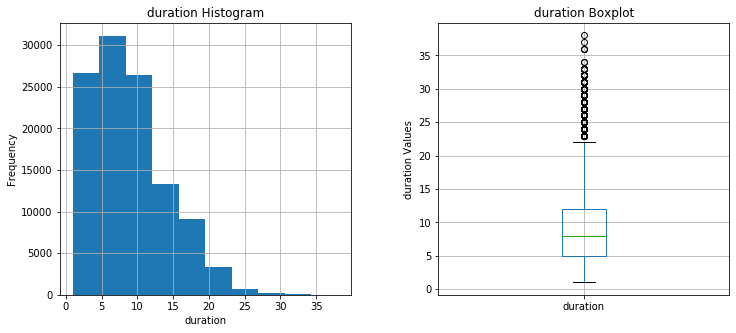

In [37]:
# lets check histograms and boxplot

fig, axes = plt.subplots(1, 2, figsize=(12,5));
calls_made['duration'].hist(ax=axes[0]);
calls_made.boxplot('duration',ax=axes[1]);

plt.subplots_adjust(wspace = 0.3);
axes[0].set_xlabel('duration');
axes[0].set_ylabel('Frequency');
axes[1].set_ylabel('duration Values');
axes[0].set_title('duration Histogram');
axes[1].set_title('duration Boxplot');

from the plots above (specially the boxplot) we can see that the values of the duration can be considered outliers from around the 22 Minutes so we will remove these using the IQR method.

In [38]:
Q1 = calls_made['duration'].quantile(0.25)
Q3 = calls_made['duration'].quantile(0.75)
IQR = Q3 - Q1
bottom_limit = Q1 - (1.5*IQR)
upper_limit = Q3 + (1.5*IQR)
if bottom_limit < 0:
    bottom_limit = 0
print('min: ',bottom_limit)
print('max: ',upper_limit)

min:  0
max:  22.5


In [39]:
calls_made_outliers = calls_made.query('duration < @bottom_limit or duration > @upper_limit')

In [40]:
calls_made_outliers

,id,user_id,call_date,duration,month
26,1001_19,1001,2018-11-15,30,11
98,1001_163,1001,2018-12-04,27,12
142,1001_244,1001,2018-12-16,27,12
317,1002_211,1002,2018-12-12,27,12
444,1003_54,1003,2018-12-21,26,12
...,...,...,...,...,...
136816,1495_273,1495,2018-10-18,26,10
137351,1498_281,1498,2018-05-29,25,5
137572,1499_41,1499,2018-12-06,23,12
137640,1499_109,1499,2018-10-11,25,10


In [41]:
# percentage of the outliers to the total calls made

len(calls_made_outliers) / len(calls_made)

0.013399338148438697

based on our calcualtion we have around 1.3% of the total calls made as outliers therfore we can drop them

In [42]:
calls_made = calls_made[~calls_made.index.isin(calls_made_outliers.index)]

In [43]:
calls_made.head(30)

,id,user_id,call_date,duration,month
0,1000_93,1000,2018-12-27,9,12
1,1000_145,1000,2018-12-27,14,12
2,1000_247,1000,2018-12-27,15,12
3,1000_309,1000,2018-12-28,6,12
4,1000_380,1000,2018-12-30,5,12
5,1000_388,1000,2018-12-31,3,12
6,1000_510,1000,2018-12-27,6,12
7,1000_521,1000,2018-12-28,15,12
8,1000_530,1000,2018-12-28,6,12
9,1000_544,1000,2018-12-26,5,12


In [44]:
 len(calls_made) / len(calls)

0.7943877736232621

after droping the missed calls (stored in a sepereate dataset) and outliers we are left with around 79% of the original data

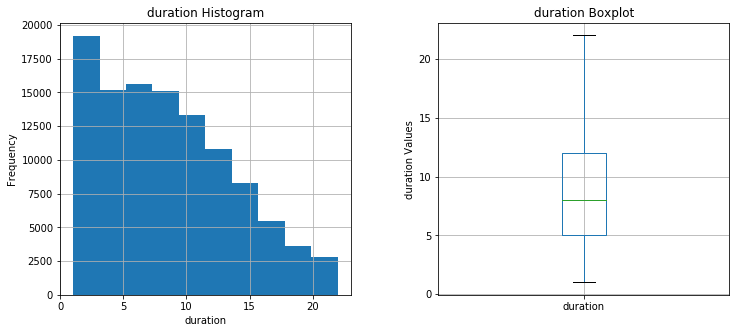

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(12,5));
calls_made['duration'].hist(ax=axes[0]);
calls_made.boxplot('duration',ax=axes[1]);

plt.subplots_adjust(wspace = 0.3);
axes[0].set_xlabel('duration');
axes[0].set_ylabel('Frequency');
axes[1].set_ylabel('duration Values');
axes[0].set_title('duration Histogram');
axes[1].set_title('duration Boxplot');

In [46]:
calls_made['duration'].describe()

count    109415.000000
mean          8.656711
std           5.041171
min           1.000000
25%           5.000000
50%           8.000000
75%          12.000000
max          22.000000
Name: duration, dtype: float64

after separating the missed calls and the outliers we see that the plot looks better and gives a clearer representaion of the actual data

In [47]:
calls['call_date'].describe()

count                  137735
unique                    351
top       2018-12-27 00:00:00
freq                     1091
first     2018-01-15 00:00:00
last      2018-12-31 00:00:00
Name: call_date, dtype: object

In [48]:
calls_made['call_date'].describe()

count                  109415
unique                    351
top       2018-12-27 00:00:00
freq                      879
first     2018-01-15 00:00:00
last      2018-12-31 00:00:00
Name: call_date, dtype: object

we see that the first call was done on 15th January which is interesting as we have half of the month with no calls and that doesn't change after cleaning the data. we have to keep this in mind. 

In [49]:
internet.head()

,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22


In [50]:
internet_original_length = len(internet)
internet_original_length

104825

In [51]:
# lets check if how many users are included in this dataset
internet['user_id'].nunique()

489

In [52]:
# lets change session_date to date_timetype

internet['session_date'] = pd.to_datetime(internet['session_date'])
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
id              104825 non-null object
user_id         104825 non-null int64
session_date    104825 non-null datetime64[ns]
mb_used         104825 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 3.2+ MB


In [53]:
internet['session_date'].describe()

count                  104825
unique                    351
top       2018-12-24 00:00:00
freq                      851
first     2018-01-15 00:00:00
last      2018-12-31 00:00:00
Name: session_date, dtype: object

- again here we find the first session recorded was in the 15th of january. so we have data only for half of january. this couuld be a trend that we need to look into
- we need the monthly usage but we will calculate it later when it is needed. for now lets add a column for the month the session was used in.

In [54]:
internet['month'] =  internet['session_date'].dt.month
internet.head()

,id,user_id,session_date,mb_used,month
0,1000_13,1000,2018-12-29,89.86,12
1,1000_204,1000,2018-12-31,0.00,12
2,1000_379,1000,2018-12-28,660.40,12
3,1000_413,1000,2018-12-26,270.99,12
4,1000_442,1000,2018-12-27,880.22,12


In [55]:
internet['month'].value_counts()

12    23492
11    18651
10    16193
9     12722
8     10718
7      8110
6      6057
5      4288
4      2558
3      1336
2       604
1        96
Name: month, dtype: int64

we notice here the same trend as in the calls' duration. the number of internet sessions increase every passing month.

In [56]:
# lets check the mb_used column

internet['mb_used'].describe()

count    104825.000000
mean        366.713701
std         277.170542
min           0.000000
25%         136.080000
50%         343.980000
75%         554.610000
max        1693.470000
Name: mb_used, dtype: float64

again as in the call duration we have sessions with zero values and we have a very high values and a difference between the mean and median. But here we have no use for the zero value sessions so we will drop them completely. 

In [57]:
# lets check the sessions with 0 values

zero_session_count = internet.loc[internet['mb_used'] == 0].count()

In [58]:
# percentage of the 0 sessions 

zero_session_count / len(internet)

id              0.131142
user_id         0.131142
session_date    0.131142
mb_used         0.131142
month           0.131142
dtype: float64

- we have around 13% of the internet dataset with 0 in mb used. we will drop them as they have no use and will affect our data.
- these values could be generated when a user has the mobile-data active on his device but didn't actualy used the internet while the sessions are recorded in specific time blocks if the mobile-data is active. 

In [59]:
internet = internet.loc[internet['mb_used']>0]

In [60]:
internet['mb_used'].describe()

count    91078.000000
mean       422.064206
std        255.063501
min          0.010000
25%        223.380000
50%        395.905000
75%        588.367500
max       1693.470000
Name: mb_used, dtype: float64

after dropping the 0 value sessions the mean and the median have vhanged but there is still a difference between them with the mean being greater it indicates that there are extreme high values which should be considered outliers and separated.

In [61]:
# lets check if there is any duplicates

internet.duplicated().sum()

0

there is no duplicates so we can continue with the preprocessing

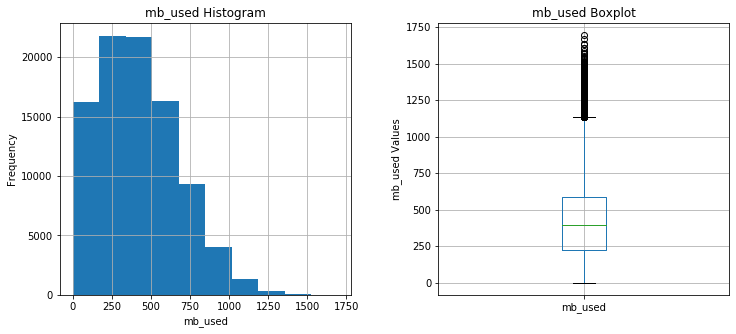

In [62]:
# lets check histograms and boxplot

fig, axes = plt.subplots(1, 2, figsize=(12,5));
internet['mb_used'].hist(ax=axes[0]);
internet.boxplot('mb_used',ax=axes[1]);

plt.subplots_adjust(wspace = 0.3);
axes[0].set_xlabel('mb_used');
axes[0].set_ylabel('Frequency');
axes[1].set_ylabel('mb_used Values');
axes[0].set_title('mb_used Histogram');
axes[1].set_title('mb_used Boxplot');

- from the graphs it is cclear that we have values in our data around 1100 which can be considered outliers
- we will use the same method (IQR) to determine the outliers and separate them

In [63]:
Q1 = internet['mb_used'].quantile(0.25)
Q3 = internet['mb_used'].quantile(0.75)
IQR = Q3 - Q1
bottom_limit = Q1 - (1.5*IQR)
upper_limit = Q3 + (1.5*IQR)
if bottom_limit < 0:
    bottom_limit = 0
print('min: ',bottom_limit)
print('max: ',upper_limit)

min:  0
max:  1135.84875


In [64]:
internet_outliers = internet.query('mb_used < @bottom_limit or mb_used > @upper_limit')

In [65]:
internet_outliers.head()

,id,user_id,session_date,mb_used,month
112,1001_210,1001,2018-09-19,1174.73,9
129,1001_233,1001,2018-12-12,1142.25,12
400,1003_26,1003,2018-12-24,1222.45,12
414,1003_40,1003,2018-12-23,1220.86,12
897,1005_11,1005,2018-12-27,1138.41,12


In [66]:
# percentage of the outliers to the total internet sessions

len(internet_outliers) / len(internet)

0.007158699137003448

we have less than 1% of the sessions as outliers so it should be ok to drop them.

In [67]:
internet = internet[~internet.index.isin(internet_outliers.index)]

In [68]:
internet.head()

,id,user_id,session_date,mb_used,month
0,1000_13,1000,2018-12-29,89.86,12
2,1000_379,1000,2018-12-28,660.40,12
3,1000_413,1000,2018-12-26,270.99,12
4,1000_442,1000,2018-12-27,880.22,12
5,1001_0,1001,2018-08-24,284.68,8


In [69]:
len(internet)/ internet_original_length

0.8626377295492488

after dropping the 0 sessions and the outliers we still have 86% of our data which should be enough for our analysis

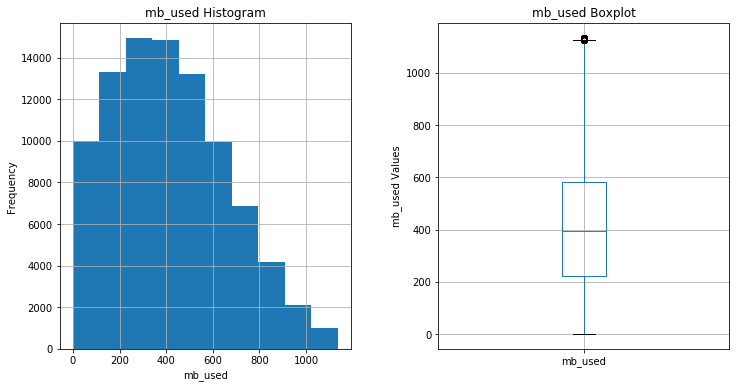

In [70]:
# lets check histograms and boxplot again

fig, axes = plt.subplots(1, 2, figsize=(12,6));
internet['mb_used'].hist(ax=axes[0]);
internet.boxplot('mb_used',ax=axes[1]);

plt.subplots_adjust(wspace = 0.3);
axes[0].set_xlabel('mb_used');
axes[0].set_ylabel('Frequency');
axes[1].set_ylabel('mb_used Values');
axes[0].set_title('mb_used Histogram');
axes[1].set_title('mb_used Boxplot');

- now our plots look better and more representative to the actual and useful data
- we notice in the boxplot that we still have some values outside or on the upper whisker we can try and lower the upper limit for the outliers but I will leave them as they should not affect our results much

In [71]:
messages.head()

,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26


In [72]:
# lets check if how many users are included in this dataset

messages['user_id'].nunique()

402

In [73]:
# lets change message_date to date_timetype

messages['message_date'] = pd.to_datetime(messages['message_date'])
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
id              76051 non-null object
user_id         76051 non-null int64
message_date    76051 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.7+ MB


In [74]:
messages['message_date'].describe()

count                   76051
unique                    351
top       2018-12-28 00:00:00
freq                      702
first     2018-01-15 00:00:00
last      2018-12-31 00:00:00
Name: message_date, dtype: object

- the trend continues here also. the first message was sent on the 15th of January

In [75]:
messages['month'] =  messages['message_date'].dt.month
messages.head()

,id,user_id,message_date,month
0,1000_125,1000,2018-12-27,12
1,1000_160,1000,2018-12-31,12
2,1000_223,1000,2018-12-31,12
3,1000_251,1000,2018-12-27,12
4,1000_255,1000,2018-12-26,12


again here we added the column `month`which shows in which month was the message sent.

In [76]:
# lets check if there is any duplicates

messages.duplicated().sum()

0

there is no duplicates so we can continue with the preprocessing

In [77]:
plans.head()

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


in the plans dataset everything looks clean and we don't need to change anything and there is clearly no duplicates

In [78]:
users.head()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,anamaria,bauer,45,"atlanta-sandy springs-roswell, ga msa",2018-12-24,ultimate,NaN
1,1001,mickey,wilkerson,28,"seattle-tacoma-bellevue, wa msa",2018-08-13,surf,NaN
2,1002,carlee,hoffman,36,"las vegas-henderson-paradise, nv msa",2018-10-21,surf,NaN
3,1003,reynaldo,jenkins,52,"tulsa, ok msa",2018-01-28,surf,NaN
4,1004,leonila,thompson,40,"seattle-tacoma-bellevue, wa msa",2018-05-23,surf,NaN


In [79]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
first_name    500 non-null object
last_name     500 non-null object
age           500 non-null int64
city          500 non-null object
reg_date      500 non-null object
plan          500 non-null object
churn_date    34 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [80]:
# lets check in the user_id in this dataset are unique

users['user_id'].nunique()

500

In [81]:
len(users)

500

- as the number of unique users is equal to the length of the entire dataset we can also conclude that there is no duplicates here to drop
- `first_name` and `last_name` strings was changed to lower case so no need to change anything further. 
-  `age` are integers so no need to change the type but we will see if it has any invalid data

In [82]:
users['age'].describe()

count    500.000000
mean      45.486000
std       16.972269
min       18.000000
25%       30.000000
50%       46.000000
75%       61.000000
max       75.000000
Name: age, dtype: float64

`age` looks ok. the customers age starts with 18 years old and have a maximum of 75 so nothing out of the norm.

In [83]:
users['city'].value_counts()

new york-newark-jersey city, ny-nj-pa msa          80
los angeles-long beach-anaheim, ca msa             29
dallas-fort worth-arlington, tx msa                21
chicago-naperville-elgin, il-in-wi msa             19
philadelphia-camden-wilmington, pa-nj-de-md msa    17
                                                   ..
jacksonville, fl msa                                1
stockton, ca msa                                    1
el paso, tx msa                                     1
albany-schenectady-troy, ny msa                     1
greensboro-high point, nc msa                       1
Name: city, Length: 73, dtype: int64

In [84]:
users['city'].nunique()

73

the customers are spread throughout a total of 73 cities. we have already changed the names to lower case so there should be no duplicate names with different cases.

In [85]:
# lets change the reg_date to datetime

users['reg_date'] = pd.to_datetime(users['reg_date'])
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
first_name    500 non-null object
last_name     500 non-null object
age           500 non-null int64
city          500 non-null object
reg_date      500 non-null datetime64[ns]
plan          500 non-null object
churn_date    34 non-null object
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 31.4+ KB


In [86]:
users['reg_date'].describe()

count                     500
unique                    266
top       2018-07-12 00:00:00
freq                        5
first     2018-01-01 00:00:00
last      2018-12-31 00:00:00
Name: reg_date, dtype: object

- it looks like our data contains only customers who registerded in 2018. with the first registered on the first day of the year (1st of January) and the last one registered on the last day (31st of december). 

In [87]:
users['plan'].value_counts()

surf        339
ultimate    161
Name: plan, dtype: int64

now lets check the `churn_date`column.

In [88]:
users['churn_date'].isna().sum()

466

this column represents the date the user stop using the services, and according to the description: if the value is missing, the calling plan was being used when this data was retrieved. therefore we can assume that all the missing values here are for the customers that are still using the services by the end of the year so to make our calculations easier we will fill them with date of the last day of the year and then change the data type to date_time

In [89]:
users['churn_date'].unique()

array([nan, '2018-12-18', '2018-11-16', '2018-09-07', '2018-12-30',
       '2018-10-07', '2018-12-31', '2018-11-24', '2018-11-11',
       '2018-12-12', '2018-11-14', '2018-12-27', '2018-11-29',
       '2018-12-22', '2018-11-30', '2018-10-13', '2018-07-31',
       '2018-12-15', '2018-12-19', '2018-10-03', '2018-10-22',
       '2018-08-16', '2018-12-26', '2018-09-01', '2018-11-21',
       '2018-08-19', '2018-12-10', '2018-09-17', '2018-11-18',
       '2018-09-18'], dtype=object)

In [90]:
users['churn_date'] = users['churn_date'].fillna('2018-12-31')

In [91]:
users.head()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,anamaria,bauer,45,"atlanta-sandy springs-roswell, ga msa",2018-12-24,ultimate,2018-12-31
1,1001,mickey,wilkerson,28,"seattle-tacoma-bellevue, wa msa",2018-08-13,surf,2018-12-31
2,1002,carlee,hoffman,36,"las vegas-henderson-paradise, nv msa",2018-10-21,surf,2018-12-31
3,1003,reynaldo,jenkins,52,"tulsa, ok msa",2018-01-28,surf,2018-12-31
4,1004,leonila,thompson,40,"seattle-tacoma-bellevue, wa msa",2018-05-23,surf,2018-12-31


In [92]:
users['churn_date'] = pd.to_datetime(users['churn_date'])

In [93]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
first_name    500 non-null object
last_name     500 non-null object
age           500 non-null int64
city          500 non-null object
reg_date      500 non-null datetime64[ns]
plan          500 non-null object
churn_date    500 non-null datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


In [94]:
users['churn_date'].describe()

count                     500
unique                     29
top       2018-12-31 00:00:00
freq                      468
first     2018-07-31 00:00:00
last      2018-12-31 00:00:00
Name: churn_date, dtype: object

- we notice that the some customers started cancelling or stop using the services starting from August and some of them were still using the services when the data was retreived. 
- we can now create a new column `days_using_service` which is the numbers of days between registering for the services and the date the customer stopped using it or the last day of the year (when the data was retrieved) if the customer is still using the service.

In [95]:
users['days_using_service'] = users['churn_date'] - users['reg_date']

In [96]:
users.head(3)

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,days_using_service
0,1000,anamaria,bauer,45,"atlanta-sandy springs-roswell, ga msa",2018-12-24,ultimate,2018-12-31,7 days
1,1001,mickey,wilkerson,28,"seattle-tacoma-bellevue, wa msa",2018-08-13,surf,2018-12-31,140 days
2,1002,carlee,hoffman,36,"las vegas-henderson-paradise, nv msa",2018-10-21,surf,2018-12-31,71 days


In [97]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
user_id               500 non-null int64
first_name            500 non-null object
last_name             500 non-null object
age                   500 non-null int64
city                  500 non-null object
reg_date              500 non-null datetime64[ns]
plan                  500 non-null object
churn_date            500 non-null datetime64[ns]
days_using_service    500 non-null timedelta64[ns]
dtypes: datetime64[ns](2), int64(2), object(4), timedelta64[ns](1)
memory usage: 35.3+ KB


we notice that in the (`calls`,`internet` and `messages`) datasets there is a column called `id` which is a special ID for every record of the variables above and it is different in every dataset so to clarify this we will change the column names to make things easier.

In [98]:
calls_made.rename(columns={"id": "call_id"}, inplace=True)
messages.rename(columns={"id": "message_id"}, inplace=True)
internet.rename(columns={"id": "session_id"}, inplace=True)

In [99]:
calls_made.head()

,call_id,user_id,call_date,duration,month
0,1000_93,1000,2018-12-27,9,12
1,1000_145,1000,2018-12-27,14,12
2,1000_247,1000,2018-12-27,15,12
3,1000_309,1000,2018-12-28,6,12
4,1000_380,1000,2018-12-30,5,12


In [100]:
messages.head()

,message_id,user_id,message_date,month
0,1000_125,1000,2018-12-27,12
1,1000_160,1000,2018-12-31,12
2,1000_223,1000,2018-12-31,12
3,1000_251,1000,2018-12-27,12
4,1000_255,1000,2018-12-26,12


In [101]:
internet.head()

,session_id,user_id,session_date,mb_used,month
0,1000_13,1000,2018-12-29,89.86,12
2,1000_379,1000,2018-12-28,660.40,12
3,1000_413,1000,2018-12-26,270.99,12
4,1000_442,1000,2018-12-27,880.22,12
5,1001_0,1001,2018-08-24,284.68,8


## Notes and Conclusion:

1. in this step we prepared the datasets for work and done some preprocessing.
2. all of the `date` columns were changed to data_time type
3. all the string columns were changed to lower case
4. the `id` column in the datasets (`calls`,`internet` and `messages`) was changed to be clearer.
5. in the (`calls`,`internet` and `messages`)datasets we added a new column the shows the month every record was made in.
6. in the `duration` and `mb_used` columns we addressed the following points:
 - the zero values: 
    1. in `duration` they were seprated into a new dataset `missed_calls` then dropped and the final data was saved in `calls_made`
    2. in `mb_used` they were dropped completely
 - the outliers: in both `duration` and `mb_used` we separated the outliers using the (IQR) method and then dropped them from the original data
7. we added the column `days_using_service`to the `users` dataset which give us the number of days every user used our services in the year 2018
8. after finishing preprocessing we kept around 79% of the `calls` data, around 86% of the `internet`data and 100% of the other datasets
9. we noticed a trend the the first usage record for every type (calls, internet and messages) was in 15th of January but the first user registered in 1st of January. there is around 2 weeks difference from registeration adn first use therefore it could be that this is an activation period.

Now we will start grouping the data to find the following values: 

- The number of calls made and minutes used per month
- The number of text messages sent per month
- The volume of data per month
- The monthly revenue from each user (subtract the free package limit from the total number of calls, text messages, and data; multiply the result by the calling plan value; add the monthly charge depending on the calling plan)

In [102]:
# lets find The number of calls made and minutes used per month
calls_grouped = calls_made.pivot_table(index=['user_id', 'month'], values='duration', aggfunc=['sum', 'count'])

In [103]:
calls_grouped

sum    count
              duration duration
user_id month                  
1000    12         124       16
1001    8          182       22
        9          315       38
        10         393       47
        11         396       48
...                ...      ...
1498    12         339       32
1499    9          322       34
        10         360       40
        11         308       39
        12         473       55

[2256 rows x 2 columns]

In [104]:
calls_grouped.columns = ['calls_duration', 'calls_count']
calls_grouped.head()

calls_duration  calls_count
user_id month                             
1000    12                124           16
1001    8                 182           22
        9                 315           38
        10                393           47
        11                396           48

In [105]:
# calls_grouped_1 = calls_made.groupby(['user_id','month']).agg({'duration':['sum', 'count']})

In [106]:
# lets find The number of text messages sent per month
messages_grouped = messages.pivot_table(index=['user_id', 'month'], values = 'message_id', aggfunc='count')

In [107]:
messages_grouped.head()

message_id
user_id month            
1000    12             11
1001    8              30
        9              44
        10             53
        11             36

In [108]:
messages_grouped.columns = ['messages_count']
messages_grouped.head()

messages_count
user_id month                
1000    12                 11
1001    8                  30
        9                  44
        10                 53
        11                 36

In [109]:
# lets find The volume of data per month
internet_grouped = internet.pivot_table(index=['user_id', 'month'], values = 'mb_used', aggfunc='sum')

In [110]:
internet_grouped.head()

mb_used
user_id month          
1000    12      1901.47
1001    8       6919.15
        9      12140.09
        10     22330.49
        11     18504.30

In [111]:
internet_grouped.columns = ['Volume_used']
internet_grouped.head()

Volume_used
user_id month             
1000    12         1901.47
1001    8          6919.15
        9         12140.09
        10        22330.49
        11        18504.30

In [112]:
users.head()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,days_using_service
0,1000,anamaria,bauer,45,"atlanta-sandy springs-roswell, ga msa",2018-12-24,ultimate,2018-12-31,7 days
1,1001,mickey,wilkerson,28,"seattle-tacoma-bellevue, wa msa",2018-08-13,surf,2018-12-31,140 days
2,1002,carlee,hoffman,36,"las vegas-henderson-paradise, nv msa",2018-10-21,surf,2018-12-31,71 days
3,1003,reynaldo,jenkins,52,"tulsa, ok msa",2018-01-28,surf,2018-12-31,337 days
4,1004,leonila,thompson,40,"seattle-tacoma-bellevue, wa msa",2018-05-23,surf,2018-12-31,222 days


In [113]:
user_pivot = users.pivot_table(index = 'user_id', values= 'plan' , aggfunc = 'first')

In [114]:
print(len(user_pivot))
user_pivot.head()

500


,plan
user_id,
1000,ultimate
1001,surf
1002,surf
1003,surf
1004,surf


In [115]:
plans

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


 after grouping the data in each category by the `user_id` we will merge them all together in one dataset and then we will add to it the plan used by this user and the details of this plan and calculate the overall paymet for each user per month

In [116]:
data_to_merge = [calls_grouped,messages_grouped,internet_grouped]

In [117]:
grouped_data = reduce(lambda  left,right: pd.merge(left,right,on=['user_id', 'month'], how='outer'), data_to_merge)

In [118]:
grouped_data = grouped_data.fillna(0)
grouped_data

calls_duration  calls_count  messages_count  Volume_used
user_id month                                                          
1000    12              124.0         16.0            11.0      1901.47
1001    8               182.0         22.0            30.0      6919.15
        9               315.0         38.0            44.0     12140.09
        10              393.0         47.0            53.0     22330.49
        11              396.0         48.0            36.0     18504.30
...                       ...          ...             ...          ...
1407    11                0.0          0.0             1.0       290.06
1482    10                0.0          0.0             2.0         0.00
1094    10                0.0          0.0             0.0      1728.71
1108    12                0.0          0.0             0.0       233.17
1311    6                 0.0          0.0             0.0      1498.83

[2293 rows x 4 columns]

In [119]:
len(grouped_data)

2293

In [120]:
index_array = grouped_data.index
index_array

MultiIndex([(1000, 12),
            (1001,  8),
            (1001,  9),
            (1001, 10),
            (1001, 11),
            (1001, 12),
            (1002, 10),
            (1002, 11),
            (1002, 12),
            (1003, 12),
            ...
            (1224,  6),
            (1349, 10),
            (1349, 11),
            (1349, 12),
            (1361,  5),
            (1407, 11),
            (1482, 10),
            (1094, 10),
            (1108, 12),
            (1311,  6)],
           names=['user_id', 'month'], length=2293)

In [121]:
index_level_id = []
for index in index_array:
    if index[0] not in index_level_id:
        index_level_id.append(index[0])

In [122]:
unique_id = len(index_level_id)
#unique_id = pd.Series(index_level_id).nunique()
unique_id

490

we notice that not all the users are using thier plan therefore we will have extra rows after merging the data with the `user_pivot` to take the plan name. we will have to drop these rows so they don't affect our calculations. we will do this by filling the NAN values in these rows with 0, this will fill the `month` with 0 then will drop these rows.

In [123]:
grouped_data.reset_index(level='month', inplace=True)

In [124]:
# adding the plan name
grouped_data_2 = pd.merge(left = user_pivot , right = grouped_data, how='outer', on='user_id')

In [125]:
grouped_data_2.head(10)

,plan,month,calls_duration,calls_count,messages_count,Volume_used
user_id,,,,,,
1000,ultimate,12.0,124.0,16.0,11.0,1901.47
1001,surf,8.0,182.0,22.0,30.0,6919.15
1001,surf,9.0,315.0,38.0,44.0,12140.09
1001,surf,10.0,393.0,47.0,53.0,22330.49
1001,surf,11.0,396.0,48.0,36.0,18504.30
1001,surf,12.0,358.0,44.0,44.0,18226.93
1002,surf,10.0,59.0,8.0,15.0,6552.01
1002,surf,11.0,386.0,48.0,32.0,19345.08
1002,surf,12.0,357.0,37.0,41.0,14396.24


In [126]:
grouped_data_2.rename(columns={"plan": "plan_name"}, inplace=True)

In [127]:
grouped_data_2

,plan_name,month,calls_duration,calls_count,messages_count,Volume_used
user_id,,,,,,
1000,ultimate,12.0,124.0,16.0,11.0,1901.47
1001,surf,8.0,182.0,22.0,30.0,6919.15
1001,surf,9.0,315.0,38.0,44.0,12140.09
1001,surf,10.0,393.0,47.0,53.0,22330.49
1001,surf,11.0,396.0,48.0,36.0,18504.30
...,...,...,...,...,...,...
1498,surf,12.0,339.0,32.0,0.0,23137.69
1499,surf,9.0,322.0,34.0,0.0,12984.76
1499,surf,10.0,360.0,40.0,0.0,19492.43


In [128]:
grouped_data_2.reset_index(level='user_id', inplace = True)

In [129]:
# adding the plans details for each user
grouped_data = pd.merge(left = grouped_data_2 , right = plans, how='left', on='plan_name')
len(grouped_data)

2303

we notice that the grouped dataset has now 10 rows more than the original grouped dataset

In [130]:
grouped_data.head(15).sort_values('user_id')

,user_id,plan_name,month,calls_duration,calls_count,messages_count,Volume_used,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute
0,1000,ultimate,12.0,124.0,16.0,11.0,1901.47,1000,30720,3000,70,7,0.01,0.01
1,1001,surf,8.0,182.0,22.0,30.0,6919.15,50,15360,500,20,10,0.03,0.03
2,1001,surf,9.0,315.0,38.0,44.0,12140.09,50,15360,500,20,10,0.03,0.03
3,1001,surf,10.0,393.0,47.0,53.0,22330.49,50,15360,500,20,10,0.03,0.03
4,1001,surf,11.0,396.0,48.0,36.0,18504.30,50,15360,500,20,10,0.03,0.03
5,1001,surf,12.0,358.0,44.0,44.0,18226.93,50,15360,500,20,10,0.03,0.03
6,1002,surf,10.0,59.0,8.0,15.0,6552.01,50,15360,500,20,10,0.03,0.03
7,1002,surf,11.0,386.0,48.0,32.0,19345.08,50,15360,500,20,10,0.03,0.03
8,1002,surf,12.0,357.0,37.0,41.0,14396.24,50,15360,500,20,10,0.03,0.03
9,1003,surf,12.0,1052.0,116.0,50.0,24600.83,50,15360,500,20,10,0.03,0.03


In [131]:
# filling the NAN after merging
grouped_data = grouped_data.fillna(0)

In [132]:
#droping the new rows created after merging
grouped_data = grouped_data.loc[grouped_data['month'] != 0]
len(grouped_data)

2293

now the grouped data has again the original number of rows and we can continue our work

In [133]:
grouped_data.head()

,user_id,plan_name,month,calls_duration,calls_count,messages_count,Volume_used,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute
0,1000,ultimate,12.0,124.0,16.0,11.0,1901.47,1000,30720,3000,70,7,0.01,0.01
1,1001,surf,8.0,182.0,22.0,30.0,6919.15,50,15360,500,20,10,0.03,0.03
2,1001,surf,9.0,315.0,38.0,44.0,12140.09,50,15360,500,20,10,0.03,0.03
3,1001,surf,10.0,393.0,47.0,53.0,22330.49,50,15360,500,20,10,0.03,0.03
4,1001,surf,11.0,396.0,48.0,36.0,18504.30,50,15360,500,20,10,0.03,0.03


In [134]:
# function for calcualting the overall payment for each user per month

def calculate(row):
    extra_min = 0
    extra_mes = 0
    extra_mb = 0
    extra_gb = 0
    
    def cal_min(row):   # calulating the bonus_pay for minutes
        if row['calls_duration'] <= row['minutes_included']:
            extra_min = 0
        else:
            extra_min = row['calls_duration'] - row['minutes_included']
        min_pay = extra_min * row['usd_per_minute']
        return  min_pay
    
    def cal_mes(row):    # calulating the bonus_pay for messages
        if row['messages_count'] <= row['messages_included']:
            extra_mes = 0
        else:
            extra_mes = row['messages_count'] - row['messages_included']
        mes_pay = extra_mes * row['usd_per_message']
        return  mes_pay
        
    
    def cal_mb(row):   # calulating the bonus_pay for internet 
        if row['Volume_used'] <= row['mb_per_month_included']:
            extra_gb = 0
        else:
            extra_mb = row['Volume_used'] - row['mb_per_month_included']
            extra_gb = np.ceil(extra_mb / 1024)
        gb_pay = extra_gb * row['usd_per_gb']
        return  gb_pay
    
    min_pay = cal_min(row)
    mes_pay = cal_mes(row)
    gb_pay = cal_mb(row)
    total_pay = row['usd_monthly_pay'] + min_pay + mes_pay + gb_pay  # overall payment
    return total_pay
    

In [135]:
grouped_data['total_pay'] = grouped_data.apply(calculate, axis=1)

In [136]:
grouped_data.head(15)

,user_id,plan_name,month,calls_duration,calls_count,messages_count,Volume_used,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,total_pay
0,1000,ultimate,12.0,124.0,16.0,11.0,1901.47,1000,30720,3000,70,7,0.01,0.01,70.00
1,1001,surf,8.0,182.0,22.0,30.0,6919.15,50,15360,500,20,10,0.03,0.03,20.00
2,1001,surf,9.0,315.0,38.0,44.0,12140.09,50,15360,500,20,10,0.03,0.03,20.00
3,1001,surf,10.0,393.0,47.0,53.0,22330.49,50,15360,500,20,10,0.03,0.03,90.09
4,1001,surf,11.0,396.0,48.0,36.0,18504.30,50,15360,500,20,10,0.03,0.03,60.00
5,1001,surf,12.0,358.0,44.0,44.0,18226.93,50,15360,500,20,10,0.03,0.03,50.00
6,1002,surf,10.0,59.0,8.0,15.0,6552.01,50,15360,500,20,10,0.03,0.03,20.00
7,1002,surf,11.0,386.0,48.0,32.0,19345.08,50,15360,500,20,10,0.03,0.03,60.00
8,1002,surf,12.0,357.0,37.0,41.0,14396.24,50,15360,500,20,10,0.03,0.03,20.00
9,1003,surf,12.0,1052.0,116.0,50.0,24600.83,50,15360,500,20,10,0.03,0.03,136.56


In [137]:
# grouping the data again per user_id and month to give us a better view
grouped_data_user = grouped_data.pivot_table(index = ['user_id', 'month'], values='total_pay', aggfunc='first')

In [138]:
grouped_data_user.head(15)

total_pay
user_id month           
1000    12.0       70.00
1001    8.0        20.00
        9.0        20.00
        10.0       90.09
        11.0       60.00
        12.0       50.00
1002    10.0       20.00
        11.0       60.00
        12.0       20.00
1003    12.0      136.56
1004    5.0        20.00
        6.0        80.00
        7.0       110.00
        8.0       150.00
        9.0        60.00

In [139]:
grouped_data_plan = grouped_data.pivot_table(index = 'plan_name', columns= 'month' , values='total_pay', aggfunc='sum')

In [140]:
grouped_data_plan

month,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0
plan_name,,,,,,,,,,,,
surf,40.0,307.08,1025.0,1954.37,3450.19,4552.44,7241.64,9826.86,10757.66,14771.46,15567.65,21215.44
ultimate,280.0,490.00,861.0,1519.00,2037.00,3325.00,4235.00,5117.00,6160.00,7616.00,9037.00,10969.00


In [141]:
# adding 2 columns for the monthly_average and total_per_year
grouped_data_plan['monthly_average'] = grouped_data_plan.mean(axis=1)
grouped_data_plan['overall_year'] = grouped_data_plan.sum(axis=1)

In [142]:
grouped_data_plan

month,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,monthly_average,overall_year
plan_name,,,,,,,,,,,,,,
surf,40.0,307.08,1025.0,1954.37,3450.19,4552.44,7241.64,9826.86,10757.66,14771.46,15567.65,21215.44,7559.149167,98268.939167
ultimate,280.0,490.00,861.0,1519.00,2037.00,3325.00,4235.00,5117.00,6160.00,7616.00,9037.00,10969.00,4303.833333,55949.833333


In [143]:
# counting the users for each plan
users_plan_count = users.pivot_table(index='plan', values='user_id', aggfunc='count')

In [144]:
users_plan_count

,user_id
plan,
surf,339
ultimate,161


In [145]:
# calculating the yearly average revenue per user
grouped_data_plan['yearly_average_per_user'] = grouped_data_plan['overall_year'] / users_plan_count['user_id']

In [146]:
grouped_data_plan

month,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,monthly_average,overall_year,yearly_average_per_user
plan_name,,,,,,,,,,,,,,,
surf,40.0,307.08,1025.0,1954.37,3450.19,4552.44,7241.64,9826.86,10757.66,14771.46,15567.65,21215.44,7559.149167,98268.939167,289.878877
ultimate,280.0,490.00,861.0,1519.00,2037.00,3325.00,4235.00,5117.00,6160.00,7616.00,9037.00,10969.00,4303.833333,55949.833333,347.514493


In [147]:
grouped_data_plan

month,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,monthly_average,overall_year,yearly_average_per_user
plan_name,,,,,,,,,,,,,,,
surf,40.0,307.08,1025.0,1954.37,3450.19,4552.44,7241.64,9826.86,10757.66,14771.46,15567.65,21215.44,7559.149167,98268.939167,289.878877
ultimate,280.0,490.00,861.0,1519.00,2037.00,3325.00,4235.00,5117.00,6160.00,7616.00,9037.00,10969.00,4303.833333,55949.833333,347.514493


In [148]:
users.head()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,days_using_service
0,1000,anamaria,bauer,45,"atlanta-sandy springs-roswell, ga msa",2018-12-24,ultimate,2018-12-31,7 days
1,1001,mickey,wilkerson,28,"seattle-tacoma-bellevue, wa msa",2018-08-13,surf,2018-12-31,140 days
2,1002,carlee,hoffman,36,"las vegas-henderson-paradise, nv msa",2018-10-21,surf,2018-12-31,71 days
3,1003,reynaldo,jenkins,52,"tulsa, ok msa",2018-01-28,surf,2018-12-31,337 days
4,1004,leonila,thompson,40,"seattle-tacoma-bellevue, wa msa",2018-05-23,surf,2018-12-31,222 days


now lets group the data in separate datasets based on the plan

In [149]:
grouped_data.head(3)

,user_id,plan_name,month,calls_duration,calls_count,messages_count,Volume_used,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,total_pay
0,1000,ultimate,12.0,124.0,16.0,11.0,1901.47,1000,30720,3000,70,7,0.01,0.01,70.0
1,1001,surf,8.0,182.0,22.0,30.0,6919.15,50,15360,500,20,10,0.03,0.03,20.0
2,1001,surf,9.0,315.0,38.0,44.0,12140.09,50,15360,500,20,10,0.03,0.03,20.0


In [150]:
# lets add a new column for the monthly volume used in GB instead of MB
grouped_data['gb_used'] = np.ceil(grouped_data['Volume_used'] / 1024)

In [151]:
grouped_data.head(3)

,user_id,plan_name,month,calls_duration,calls_count,messages_count,Volume_used,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,total_pay,gb_used
0,1000,ultimate,12.0,124.0,16.0,11.0,1901.47,1000,30720,3000,70,7,0.01,0.01,70.0,2.0
1,1001,surf,8.0,182.0,22.0,30.0,6919.15,50,15360,500,20,10,0.03,0.03,20.0,7.0
2,1001,surf,9.0,315.0,38.0,44.0,12140.09,50,15360,500,20,10,0.03,0.03,20.0,12.0


In [152]:
surf = grouped_data.loc[grouped_data['plan_name'] == 'surf']
surf.head()

,user_id,plan_name,month,calls_duration,calls_count,messages_count,Volume_used,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,total_pay,gb_used
1,1001,surf,8.0,182.0,22.0,30.0,6919.15,50,15360,500,20,10,0.03,0.03,20.00,7.0
2,1001,surf,9.0,315.0,38.0,44.0,12140.09,50,15360,500,20,10,0.03,0.03,20.00,12.0
3,1001,surf,10.0,393.0,47.0,53.0,22330.49,50,15360,500,20,10,0.03,0.03,90.09,22.0
4,1001,surf,11.0,396.0,48.0,36.0,18504.30,50,15360,500,20,10,0.03,0.03,60.00,19.0
5,1001,surf,12.0,358.0,44.0,44.0,18226.93,50,15360,500,20,10,0.03,0.03,50.00,18.0


In [153]:
ultimate = grouped_data.loc[grouped_data['plan_name'] == 'ultimate']
ultimate.head()

,user_id,plan_name,month,calls_duration,calls_count,messages_count,Volume_used,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,total_pay,gb_used
0,1000,ultimate,12.0,124.0,16.0,11.0,1901.47,1000,30720,3000,70,7,0.01,0.01,70.0,2.0
19,1006,ultimate,11.0,10.0,2.0,15.0,2068.37,1000,30720,3000,70,7,0.01,0.01,70.0,3.0
20,1006,ultimate,12.0,59.0,7.0,139.0,29559.08,1000,30720,3000,70,7,0.01,0.01,70.0,29.0
26,1008,ultimate,10.0,452.0,53.0,21.0,17106.99,1000,30720,3000,70,7,0.01,0.01,70.0,17.0
27,1008,ultimate,11.0,393.0,48.0,37.0,23676.72,1000,30720,3000,70,7,0.01,0.01,70.0,24.0


now lets group these data sets based on `user_id `and find the average monthly for each user

In [154]:
surf_monthly_pay = surf.groupby(['user_id','month'])['total_pay'].sum().groupby(['user_id']).mean().to_frame().reset_index()
print(len(surf_monthly_pay))
surf_monthly_pay.head()

333


,user_id,total_pay
0,1001,48.018000
1,1002,33.333333
2,1003,136.560000
3,1004,76.250000
4,1005,30.000000


In [155]:
ultimate_monthly_pay = ultimate.groupby(['user_id','month'])['total_pay'].sum().groupby(['user_id']).mean().to_frame().reset_index()
print(len(ultimate_monthly_pay))
ultimate_monthly_pay.head()

157


,user_id,total_pay
0,1000,70.0
1,1006,70.0
2,1008,70.0
3,1011,70.0
4,1013,70.0


In [156]:
print('surf_monthly_pay_mean =', surf_monthly_pay['total_pay'].mean())
print('ultimate_monthly_pay_mean =', ultimate_monthly_pay['total_pay'].mean())

surf_monthly_pay_mean = 55.09972679389346
ultimate_monthly_pay_mean = 71.39973621565977


In [157]:
grouped_data_plan

month,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,monthly_average,overall_year,yearly_average_per_user
plan_name,,,,,,,,,,,,,,,
surf,40.0,307.08,1025.0,1954.37,3450.19,4552.44,7241.64,9826.86,10757.66,14771.46,15567.65,21215.44,7559.149167,98268.939167,289.878877
ultimate,280.0,490.00,861.0,1519.00,2037.00,3325.00,4235.00,5117.00,6160.00,7616.00,9037.00,10969.00,4303.833333,55949.833333,347.514493


### Conclusion

- from the dataframes above we can notice that the `overall_year` and `monthly_average` income from the 'Surf' plan is higher than it is from the 'Ultimate' plan
- when the number of users for each plan is counted for we find that `yearly_average_per_user` from the 'Ultimate' plan is higher than it is from the 'Surf' plan 
- all of this doesn't give us a clear view as we didn't take the number of month every user used the plan into consideration that's why we grouped the data based on plan then user id and found the datasets `surf_monthly_pay` and `ultimate_monthly_pay` and then calculated the average monthly payment for a user in these plans and from it we can conclude that on average a user that uses the `surf` plan pays monthly around 55 USD which is less than the average a user that uses the `ultimate` plan pays and tha'S around 71 usd
- we can see the a user with the `surf` plan pays around 35 usd as extra_fee every month but the user with `ultimate` plan pays only 1-2 usd extra fees.
- we can't come to a final conclusion from this alone so we will continue our analysis further and compare the average monthly minutes, messages and internet volume for a user in both plans

# Step 3. Analyze the data


in this step we will analyze the data by calculationing the following values for the minutes, texts, and volume of data the users of each plan require per month:
1. mean
2. Dispersion
3. standard deviation
4. ploting histograms 


In [158]:
surf_minutes = surf.groupby(['user_id','month'])['calls_duration'].sum().groupby(['user_id']).mean().to_frame().reset_index()
surf_minutes.head()

,user_id,calls_duration
0,1001,328.800000
1,1002,267.333333
2,1003,1052.000000
3,1004,321.875000
4,1005,449.000000


In [159]:
ultimate_minutes = ultimate.groupby(['user_id','month'])['calls_duration'].sum().groupby(['user_id']).mean().to_frame().reset_index()
ultimate_minutes.head()

,user_id,calls_duration
0,1000,124.000000
1,1006,34.500000
2,1008,469.666667
3,1011,399.714286
4,1013,219.000000


In [160]:
print('surf_min_mean =', surf_minutes['calls_duration'].mean())
print('unltimate_min_mean =', ultimate_minutes['calls_duration'].mean())
print('surf_min_median =', surf_minutes['calls_duration'].median())
print('unltimate_min_median =', ultimate_minutes['calls_duration'].median())
print('surf_min_dispersion =', surf_minutes['calls_duration'].var())
print('unltimate_min_dispersion =', ultimate_minutes['calls_duration'].var())
print('surf_min_std =', surf_minutes['calls_duration'].std())
print('unltimate_min_std =', ultimate_minutes['calls_duration'].std())

surf_min_mean = 393.19267340934005
unltimate_min_mean = 391.99782653652085
surf_min_median = 377.6666666666667
unltimate_min_median = 396.0
surf_min_dispersion = 36668.48663073942
unltimate_min_dispersion = 37612.84878521428
surf_min_std = 191.49017371849507
unltimate_min_std = 193.94032274185346


lets compare the mean of used minutes for every plan with the number of minutes included in that plan

In [161]:
plans

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


In [162]:
print('surf_min_mean =', surf_minutes['calls_duration'].mean())
print('surf_min_included =', plans.iloc[0]['minutes_included'])
print('unltimate_min_mean =', ultimate_minutes['calls_duration'].mean())
print('unltimate_min_included =', plans.iloc[1]['minutes_included'])

surf_min_mean = 393.19267340934005
surf_min_included = 500
unltimate_min_mean = 391.99782653652085
unltimate_min_included = 3000


- from the values above we notice that the mean monthly minutes for a user in the `surf` plan is 2 minutes higher than the mean monthly minutes for a user in the `ultimate` plan but in general terms we can say that they use almost the same amount of monthly minutes.
- as the mean in the `surf` plan is higher than the median then it is most likely that the distribution is positively skewed and there are high outliers.
- as the mean in the `ultimate` plan is lower than the median then it is most likely that the distribution is negatively skewed.
- we notice that the variance and standard deviation for the average monthly minutes in the `surf` plan is slightly lower than those in the `ultimate` plan which can point out that the behavior of users in the `ultimate` is more volatiale than the behavior of the users in the `surf` plan.
- the average monthly minutes used by users in the `surf` plan is around '400' which is close to the number of minutes included in the plan which makes more probable that they go over the limit and uses extra minutes which will issue extra fees but on the other hand the average monthly minutes used by users in the `ultimate` plan is also around '400' but it is way far from the number of minutes included in the plan therefore it is very unprobable that they will go over the limit and pay extra fees.

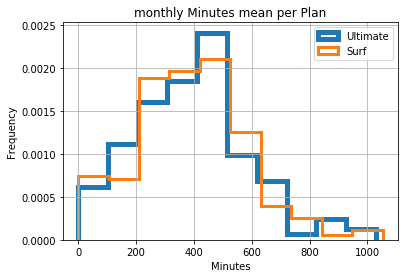

In [163]:
plt.hist(ultimate_minutes['calls_duration'],density = True, histtype ='step', linewidth = 5, label='Ultimate');
plt.hist(surf_minutes['calls_duration'],density = True, histtype ='step', linewidth = 3, label='Surf');

plt.title("monthly Minutes mean per Plan");
plt.xlabel("Minutes");
plt.ylabel("Frequency");
plt.grid();
plt.legend();

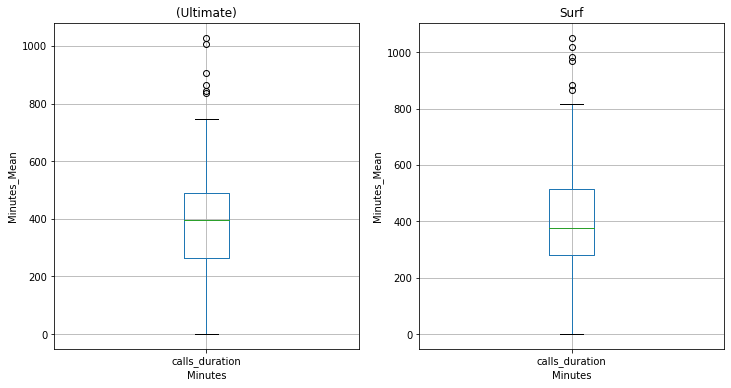

In [164]:
fig, axes = plt.subplots(1, 2, figsize=(12,6));
ultimate_minutes.boxplot('calls_duration',  ax=axes[0]);
surf_minutes.boxplot('calls_duration',  ax=axes[1]);

#plt.subplots_adjust(wspace = 0.3);
axes[0].set_xlabel('Minutes');
axes[1].set_xlabel('Minutes');
axes[0].set_ylabel('Minutes_Mean');
axes[1].set_ylabel('Minutes_Mean');
axes[0].set_title('(Ultimate)');
axes[1].set_title('Surf');

from the graphs above (and it is more obvious in the  box plots) we notice that the distribution for the average monthly minutes used by users with `ultimate` plan has a slightly negative skew but on the other hand the distribution for the average monthly minutes used by users with `surf` plan has a slightly positive skew which exactly what we noticed from the values above


In [165]:
surf_messages = surf.groupby(['user_id','month'])['messages_count'].sum().groupby(['user_id']).mean().to_frame().reset_index()
surf_messages.head()

,user_id,messages_count
0,1001,41.400000
1,1002,29.333333
2,1003,50.000000
3,1004,22.125000
4,1005,11.000000


In [166]:
ultimate_messages = ultimate.groupby(['user_id','month'])['messages_count'].sum().groupby(['user_id']).mean().to_frame().reset_index()
ultimate_messages.head()

,user_id,messages_count
0,1000,11.0
1,1006,77.0
2,1008,28.0
3,1011,53.0
4,1013,16.0


In [167]:
print('surf_mes_mean =', surf_messages['messages_count'].mean())
print('unltimate_mes_mean =', ultimate_messages['messages_count'].mean())
print('surf_mes_median =', surf_messages['messages_count'].median())
print('unltimate_mes_median =', ultimate_messages['messages_count'].median())
print('surf_mes_dispersion =', surf_messages['messages_count'].var())
print('unltimate_mes_dispersion =', ultimate_messages['messages_count'].var())
print('surf_mes_std =', surf_messages['messages_count'].std())
print('unltimate_mes_std =', ultimate_messages['messages_count'].std())

surf_mes_mean = 32.40893079226412
unltimate_mes_mean = 38.471532200990794
surf_mes_median = 27.0
unltimate_mes_median = 32.5
surf_mes_dispersion = 962.1025147660129
unltimate_mes_dispersion = 1084.205410064735
surf_mes_std = 31.017777398872617
unltimate_mes_std = 32.92727456174797


lets compare the mean of used messages for every plan with the number of messages included in that plan

In [168]:
print('surf_mes_mean =', surf_messages['messages_count'].mean())
print('surf_mes_included =', plans.iloc[0]['messages_included'])
print('unltimate_mes_mean =', ultimate_messages['messages_count'].mean())
print('unltimate_mes_included =', plans.iloc[1]['messages_included'])

surf_mes_mean = 32.40893079226412
surf_mes_included = 50
unltimate_mes_mean = 38.471532200990794
unltimate_mes_included = 1000


- from the values above we notice that the mean monthly minutes for a user in the `ultimate` plan is 5 messages higher than the mean monthly minutes for a user in the `surf` plan
- as the mean in the `surf` and `ultimate` plan is higher than the median then it is most likely that the distribution is positively skewed and there are high outliers.
- we notice that the variance and standard deviation for the average monthly messages in the `surf` plan is slightly lower than those in the `ultimate` plan which can point out that the behavior of users in the `ultimate` is more volatiale than the behavior of the users in the `surf` plan.
- the average monthly messages used by users in the `surf` plan is around '33' which is somewhat close to the number of messages included in the plan which makes itsomehow but not likely possible that they go over the limit and uses extra messages which will issue extra fees but on the other hand the average monthly messages used by users in the `ultimate` plan is around '39' but it is way far from the number of messages included in the plan therefore it is very unprobable that they will go over the limit and pay extra fees.

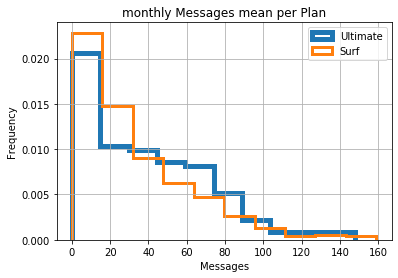

In [169]:
plt.hist(ultimate_messages['messages_count'],density = True, histtype ='step', linewidth = 5, label='Ultimate');
plt.hist(surf_messages['messages_count'],density = True, histtype ='step', linewidth = 3, label='Surf');

plt.title("monthly Messages mean per Plan");
plt.xlabel("Messages");
plt.ylabel("Frequency");
plt.grid();
plt.legend();

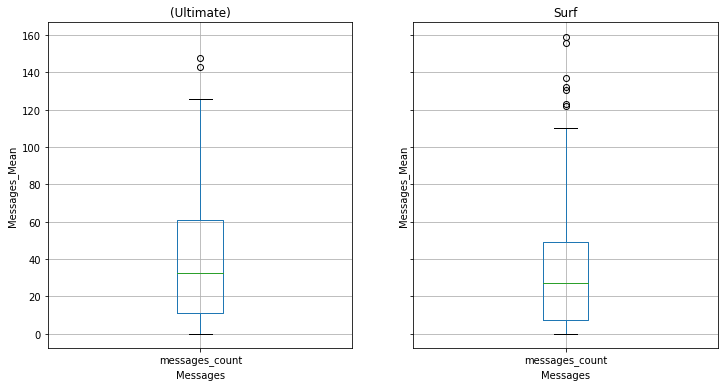

In [170]:
fig, axes = plt.subplots(1, 2, figsize=(12,6), sharey= True);
ultimate_messages.boxplot('messages_count',  ax=axes[0]);
surf_messages.boxplot('messages_count',  ax=axes[1]);

#plt.subplots_adjust(wspace = 0.3);
axes[0].set_xlabel('Messages');
axes[1].set_xlabel('Messages');
axes[0].set_ylabel('Messages_Mean');
axes[1].set_ylabel('Messages_Mean');
axes[0].set_title('(Ultimate)');
axes[1].set_title('Surf');

from the graphs above we notice that the distribution for the average monthly messages used by users with both `ultimate` and `surf`  plans has a slightly positive skew which exactly what we noticed from the values above

In [171]:
surf_inernet = surf.groupby(['user_id','month'])['gb_used'].sum().groupby(['user_id']).mean().to_frame().reset_index()
surf_inernet.head()

,user_id,gb_used
0,1001,15.600000
1,1002,13.666667
2,1003,25.000000
3,1004,19.625000
4,1005,16.000000


In [172]:
ultimate_inernet = ultimate.groupby(['user_id','month'])['gb_used'].sum().groupby(['user_id']).mean().to_frame().reset_index()
ultimate_inernet.head()

,user_id,gb_used
0,1000,2.000000
1,1006,16.000000
2,1008,18.666667
3,1011,18.857143
4,1013,20.000000


In [173]:
print('surf_gb_mean =', surf_inernet['gb_used'].mean())
print('unltimate_gb_mean =', ultimate_inernet['gb_used'].mean())
print('surf_gb_median =', surf_inernet['gb_used'].median())
print('unltimate_gb_median =', ultimate_inernet['gb_used'].median())
print('surf_gb_dispersion =', surf_inernet['gb_used'].var())
print('unltimate_gb_dispersion =', ultimate_inernet['gb_used'].var())
print('surf_gb_std =', surf_inernet['gb_used'].std())
print('unltimate_gb_std =', ultimate_inernet['gb_used'].std())

surf_gb_mean = 15.65740231573565
unltimate_gb_mean = 15.810030008915358
surf_gb_median = 15.75
unltimate_gb_median = 15.666666666666666
surf_gb_dispersion = 34.578722283751
unltimate_gb_dispersion = 30.801275071402934
surf_gb_std = 5.880367529649061
unltimate_gb_std = 5.549889644975198


lets compare the mean of used GB for every plan with the number of GB included in that plan

In [174]:
print('surf_gb_mean =', surf_inernet['gb_used'].mean())
print('surf_GB_included =', plans.iloc[0]['mb_per_month_included'] / 1024)
print('unltimate_gb_mean =', ultimate_inernet['gb_used'].mean())
print('unltimate_GB_included =', plans.iloc[1]['mb_per_month_included'] / 1024)

surf_gb_mean = 15.65740231573565
surf_GB_included = 15.0
unltimate_gb_mean = 15.810030008915358
unltimate_GB_included = 30.0


- from the values above we notice that the mean monthly GB used for a user in the `surf` and `ultimate` plan is almost similar.
- as the mean in both the `surf` and `ultimate` plan almost equal to the median then it is most likely that the distribution is normaly distributed (symmetrical) 
- we notice that the variance and standard deviation for the average monthly GB used in the `surf` plan is slightly Higher than those in the `ultimate` plan which can point out that the behavior of users in the `surf` is more volatiale than the behavior of the users in the `ultimate` plan.
- the average monthly GB used by users in the `surf` plan is around '15 - 16' which is higher than the number of GB included in the plan which means that in they usually go over the limit and uses extra GB which will issue extra fees but on the other hand the average monthly GB used by users in the `ultimate` plan is also around '15 -16' but this is half the number of GB included in the plan therefore it is unlikely that they will go over the limit and pay extra fees.

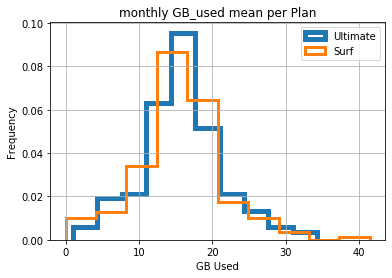

In [175]:
plt.hist(ultimate_inernet['gb_used'],density = True, histtype ='step', linewidth = 5, label='Ultimate');
plt.hist(surf_inernet['gb_used'],density = True, histtype ='step', linewidth = 3, label='Surf');

plt.title("monthly GB_used mean per Plan");
plt.xlabel("GB Used");
plt.ylabel("Frequency");
plt.grid();
plt.legend();

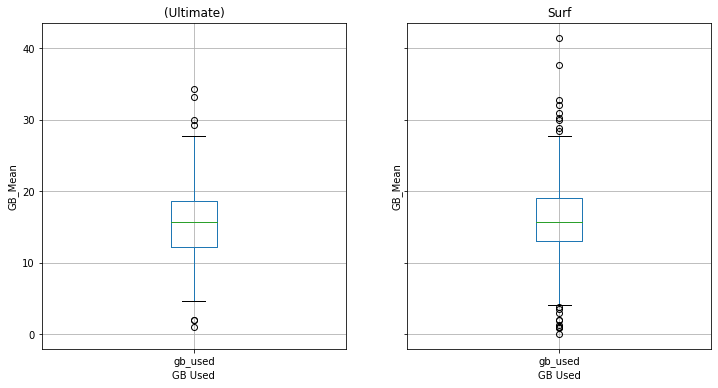

In [176]:
fig, axes = plt.subplots(1, 2, figsize=(12,6), sharey= True);
ultimate_inernet.boxplot('gb_used',  ax=axes[0]);
surf_inernet.boxplot('gb_used',  ax=axes[1]);

#plt.subplots_adjust(wspace = 0.3);
axes[0].set_xlabel('GB Used');
axes[1].set_xlabel('GB Used');
axes[0].set_ylabel('GB_Mean');
axes[1].set_ylabel('GB_Mean');
axes[0].set_title('(Ultimate)');
axes[1].set_title('Surf');

from the graphs above we notice that the distribution for the average monthly GB used by users with both `ultimate` and `surf`  plans is almost symmetrical with some high and low outliers which exactly what we noticed from the values above.

### Conclusion:

1. on average the usage of minutes, messages and Internet Volume for the users in both plans is relatively similar 
2. the users in the `surf` plan have a high probability that they go over the limits of their plan and pay extra fees which can explain that the extra '29' usd average monthly payment for users in this plan
3. the users in the `ultimate` plan almost never goes over and don't even come close to the limits over their plan therefore it is highly unlikey that they will pay any extra fees which explains the low amount of average extra monthly payment for these users '1- 2' usd
4. even though the users in both plans have the same average usage but the overal average monthly payment for the users in the `surf` plan is 20 usd less than the base fee of the `ultimate` plan which van be the reason why those users are still using their plan even though they are paying extra fees.

# Step 4. Test the hypotheses

1. The average revenue from users of Ultimate and Surf calling plans differs.
2. The average revenue from users in NY-NJ area is different from that of the users from other regions.

## Hypothesis 1: The average profit from users of Ultimate and Surf calling plans differs.¶

to test this hypothesis we will formulate the null hypotheis which will be what we are trying to reject and the alternative hypothesis:

1. H0: average profit from users of Surf = average profit from users of Ultimate
2. H1: average profit from users of Surf != average profit from users of Ultimate

we will use a standard critical statistical significance level (alpha= 0.05)

In [177]:
#lets show the datasets first
surf.head(3)

,user_id,plan_name,month,calls_duration,calls_count,messages_count,Volume_used,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,total_pay,gb_used
1,1001,surf,8.0,182.0,22.0,30.0,6919.15,50,15360,500,20,10,0.03,0.03,20.00,7.0
2,1001,surf,9.0,315.0,38.0,44.0,12140.09,50,15360,500,20,10,0.03,0.03,20.00,12.0
3,1001,surf,10.0,393.0,47.0,53.0,22330.49,50,15360,500,20,10,0.03,0.03,90.09,22.0


In [178]:
ultimate.head(3)

,user_id,plan_name,month,calls_duration,calls_count,messages_count,Volume_used,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,total_pay,gb_used
0,1000,ultimate,12.0,124.0,16.0,11.0,1901.47,1000,30720,3000,70,7,0.01,0.01,70.0,2.0
19,1006,ultimate,11.0,10.0,2.0,15.0,2068.37,1000,30720,3000,70,7,0.01,0.01,70.0,3.0
20,1006,ultimate,12.0,59.0,7.0,139.0,29559.08,1000,30720,3000,70,7,0.01,0.01,70.0,29.0


In [179]:
alpha = 0.05

results_hyp_1 = st.ttest_ind(surf_monthly_pay['total_pay'], ultimate_monthly_pay['total_pay'])

print('p_value =' ,results_hyp_1.pvalue)

if (results_hyp_1.pvalue < alpha):
    print('we reject the null hypothesis H0')
else:
    print("we don't reject the null hypothesis H0")

p_value = 8.433451255243247e-07
we reject the null hypothesis H0


In [180]:
print('surf_monthly_pay_mean =', surf_monthly_pay['total_pay'].mean())
print('ultimate_monthly_pay_mean =', ultimate_monthly_pay['total_pay'].mean())

surf_monthly_pay_mean = 55.09972679389346
ultimate_monthly_pay_mean = 71.39973621565977


In [181]:
ultimate_monthly_pay['total_pay'].mean() - surf_monthly_pay['total_pay'].mean()

16.300009421766312

from the test above we see that we have enough reason to reject the null hypothesis which means the revenue from both plan is not equal and most probably differs in one way or another. this is actualy supported by what we found earlier in Step(2): 

the values of the mean for the monthly payment for users in both plans which shows that on average the users in the `ultimate` plan pays monthly around 16 usd more than the users in the `surf` plan

## Hypothesis 2: The average revenue from users in NY-NJ area is different from that of the users from other regions.

to test this hypothesis we will formulate the null hypotheis which will be what we are trying to reject and the alternative hypothesis:

1. H0: average profit from users of ny-nj == average profit from users of other areas
2. H1: average profit from users of ny-nj != average profit from users of other areas

we will use again a standard critical statistical significance level (alpha= 0.05)

but first we need to prepare our datasets based on area

In [182]:
users.head()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,days_using_service
0,1000,anamaria,bauer,45,"atlanta-sandy springs-roswell, ga msa",2018-12-24,ultimate,2018-12-31,7 days
1,1001,mickey,wilkerson,28,"seattle-tacoma-bellevue, wa msa",2018-08-13,surf,2018-12-31,140 days
2,1002,carlee,hoffman,36,"las vegas-henderson-paradise, nv msa",2018-10-21,surf,2018-12-31,71 days
3,1003,reynaldo,jenkins,52,"tulsa, ok msa",2018-01-28,surf,2018-12-31,337 days
4,1004,leonila,thompson,40,"seattle-tacoma-bellevue, wa msa",2018-05-23,surf,2018-12-31,222 days


In [183]:
print(len(grouped_data))
grouped_data.head()

2293


,user_id,plan_name,month,calls_duration,calls_count,messages_count,Volume_used,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,total_pay,gb_used
0,1000,ultimate,12.0,124.0,16.0,11.0,1901.47,1000,30720,3000,70,7,0.01,0.01,70.00,2.0
1,1001,surf,8.0,182.0,22.0,30.0,6919.15,50,15360,500,20,10,0.03,0.03,20.00,7.0
2,1001,surf,9.0,315.0,38.0,44.0,12140.09,50,15360,500,20,10,0.03,0.03,20.00,12.0
3,1001,surf,10.0,393.0,47.0,53.0,22330.49,50,15360,500,20,10,0.03,0.03,90.09,22.0
4,1001,surf,11.0,396.0,48.0,36.0,18504.30,50,15360,500,20,10,0.03,0.03,60.00,19.0


In [184]:
# lets add the name of the user's city of residence to our grouped dataset
grouped_data['city'] = ''
for index, row in users.iterrows():
    uid = row['user_id']
    region = row['city']
    grouped_data.loc[grouped_data['user_id'] == uid, 'city'] = region

In [185]:
print(len(grouped_data))
grouped_data.head()

2293


,user_id,plan_name,month,calls_duration,calls_count,messages_count,Volume_used,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,total_pay,gb_used,city
0,1000,ultimate,12.0,124.0,16.0,11.0,1901.47,1000,30720,3000,70,7,0.01,0.01,70.00,2.0,"atlanta-sandy springs-roswell, ga msa"
1,1001,surf,8.0,182.0,22.0,30.0,6919.15,50,15360,500,20,10,0.03,0.03,20.00,7.0,"seattle-tacoma-bellevue, wa msa"
2,1001,surf,9.0,315.0,38.0,44.0,12140.09,50,15360,500,20,10,0.03,0.03,20.00,12.0,"seattle-tacoma-bellevue, wa msa"
3,1001,surf,10.0,393.0,47.0,53.0,22330.49,50,15360,500,20,10,0.03,0.03,90.09,22.0,"seattle-tacoma-bellevue, wa msa"
4,1001,surf,11.0,396.0,48.0,36.0,18504.30,50,15360,500,20,10,0.03,0.03,60.00,19.0,"seattle-tacoma-bellevue, wa msa"


In [186]:
users['city'].value_counts()

new york-newark-jersey city, ny-nj-pa msa          80
los angeles-long beach-anaheim, ca msa             29
dallas-fort worth-arlington, tx msa                21
chicago-naperville-elgin, il-in-wi msa             19
philadelphia-camden-wilmington, pa-nj-de-md msa    17
                                                   ..
jacksonville, fl msa                                1
stockton, ca msa                                    1
el paso, tx msa                                     1
albany-schenectady-troy, ny msa                     1
greensboro-high point, nc msa                       1
Name: city, Length: 73, dtype: int64

In [187]:
# lets find the cities that belong to the region ny-nj area
users['city'].loc[users['city'].str.contains('ny-nj', regex=False)].value_counts()

new york-newark-jersey city, ny-nj-pa msa    80
Name: city, dtype: int64

In [188]:
# now lets create 2 separate datasets one for this area and one for the rest
ny_nj = grouped_data.loc[grouped_data['city'] == 'new york-newark-jersey city, ny-nj-pa msa']
print(len(ny_nj))
ny_nj.head()

377


,user_id,plan_name,month,calls_duration,calls_count,messages_count,Volume_used,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,total_pay,gb_used,city
56,1014,surf,11.0,163.0,23.0,9.0,0.00,50,15360,500,20,10,0.03,0.03,20.00,0.0,"new york-newark-jersey city, ny-nj-pa msa"
57,1014,surf,12.0,1064.0,123.0,64.0,7792.41,50,15360,500,20,10,0.03,0.03,37.34,8.0,"new york-newark-jersey city, ny-nj-pa msa"
75,1022,surf,5.0,302.0,32.0,0.0,4908.08,50,15360,500,20,10,0.03,0.03,20.00,5.0,"new york-newark-jersey city, ny-nj-pa msa"
76,1022,surf,6.0,465.0,64.0,0.0,23436.48,50,15360,500,20,10,0.03,0.03,100.00,23.0,"new york-newark-jersey city, ny-nj-pa msa"
77,1022,surf,7.0,475.0,56.0,0.0,9933.15,50,15360,500,20,10,0.03,0.03,20.00,10.0,"new york-newark-jersey city, ny-nj-pa msa"


In [189]:
other_areas = grouped_data.loc[grouped_data['city'] != 'new york-newark-jersey city, ny-nj-pa msa']
print(len(other_areas))
other_areas.head()

1916


,user_id,plan_name,month,calls_duration,calls_count,messages_count,Volume_used,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,total_pay,gb_used,city
0,1000,ultimate,12.0,124.0,16.0,11.0,1901.47,1000,30720,3000,70,7,0.01,0.01,70.00,2.0,"atlanta-sandy springs-roswell, ga msa"
1,1001,surf,8.0,182.0,22.0,30.0,6919.15,50,15360,500,20,10,0.03,0.03,20.00,7.0,"seattle-tacoma-bellevue, wa msa"
2,1001,surf,9.0,315.0,38.0,44.0,12140.09,50,15360,500,20,10,0.03,0.03,20.00,12.0,"seattle-tacoma-bellevue, wa msa"
3,1001,surf,10.0,393.0,47.0,53.0,22330.49,50,15360,500,20,10,0.03,0.03,90.09,22.0,"seattle-tacoma-bellevue, wa msa"
4,1001,surf,11.0,396.0,48.0,36.0,18504.30,50,15360,500,20,10,0.03,0.03,60.00,19.0,"seattle-tacoma-bellevue, wa msa"


In [190]:
len(ny_nj) + len(other_areas) == len(grouped_data)

True

In [191]:
# lets group the new datasets and find the average user monthly revenue for the users in each dataset
ny_nj_monthly_pay = ny_nj.groupby(['user_id','month'])['total_pay'].sum().groupby(['user_id']).mean().to_frame().reset_index()
other_areas_monthly_pay = other_areas.groupby(['user_id','month'])['total_pay'].sum().groupby(['user_id']).mean().to_frame().reset_index()

ny_nj_monthly_pay.head()

,user_id,total_pay
0,1014,28.670000
1,1022,54.380000
2,1024,21.110000
3,1027,31.666667
4,1031,70.000000


In [192]:
other_areas_monthly_pay.head()

,user_id,total_pay
0,1000,70.000000
1,1001,48.018000
2,1002,33.333333
3,1003,136.560000
4,1004,76.250000


In [193]:
alpha = 0.05

results_hyp_1 = st.ttest_ind(ny_nj_monthly_pay['total_pay'], other_areas_monthly_pay['total_pay'])

print('p_value =' ,results_hyp_1.pvalue)

if (results_hyp_1.pvalue < alpha):
    print('we reject the null hypothesis H0')
else:
    print("we don't reject the null hypothesis H0")

p_value = 0.394868712064639
we don't reject the null hypothesis H0


In [194]:
print('ny_nj_monthly_pay_mean =', ny_nj_monthly_pay['total_pay'].mean())
print('other_areas_monthly_pay_mean =', other_areas_monthly_pay['total_pay'].mean())

ny_nj_monthly_pay_mean = 57.28906910424316
other_areas_monthly_pay_mean = 60.905428586350126


In [195]:
other_areas_monthly_pay['total_pay'].mean() - ny_nj_monthly_pay['total_pay'].mean()

3.616359482106965

from the test above we see that we don't have enough reason to reject the null hypothesis therfore we also can't accept the alternative hypothesis which means the revenue from users in ny-nj is close and doesn't differ much from the revenue from users in other regions. this is actualy supported by the values of the mean for the monthly payment for users in both datasets which shows that they have almost the same average with a light difference of 3 usd. 

# Final Conclusion:

in our analysis we focused on 2 areas: 
- customers behaviour 
- which plan is more profitable
and we came to the following conclusion:

1. users regarding of their plan tend to use the services in the same way.
2. more users are using the surf plan (333 users) while only (157 users) are using the ultimate plan while we have around 10 users who have registered for a plan but have never used the services.
3. users with  tend to go over the limits of their plan and pay extra fees while users with the `ultimate` plan rarely pay extra.
4. the average monthly fee for the `ultimate` plan is higher even though the users from both plans have the same usage behavior as stated above.
5. the `ultimate` plan is more profitable than the `surf` plan even though the users in the `surf`plan tend to pay extra fees around 35 usd monthly but the average payment is for the `ultimate` plan is higher.
6. there was no evidence that the ny-nj area is more profitable than other regions.

### Recommendations:

1. it is better to keep the missed calls records in separate datasets to make the work easier in the next time
2. it is better to record the internet sessions only the internet is actualy being used and not in set time blocks and or when the mobile data is active.
3. it is wiser to focus the advertising budget on the `ultimate` plan because it has less users despite being more profitable.
